In [1]:
def get_results_for_p(p,all_results):
    # Create the key as a tuple
    #key = (p.num_z,p.num_v,p.num_n,p.n_bar,p.num_q,p.q_0,p.prod_q,p.hire_c,p.k_entry,p.k_f,p.prod_alpha,p.dt)
    key = (p.num_z,p.num_v,p.num_n,p.n_bar,p.num_q,p.q_0,p.prod_q,p.hire_c,p.prod_alpha,p.dt,p.u_bf_m)
    # Check if the key exists in the saved results
    if key in all_results:
        print(key)
        return all_results[key]
    else:
        print(f"No results found for p = {key}")
        return None

from primitives import Parameters
p = Parameters()
import pickle
import matplotlib.pyplot as plt
import numpy as np
from plots import Plots
import cProfile
import pstats

plts=Plots(p)
cc_J,cc_W,cc_Wstar,cc_Jpi,cc_pc,mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n1,mwc_s_J,mwc_s_W,mwc_s_Wstar,mwc_s_sep,mwc_sd_J,mwc_sd_W,mwc_sd_Wstar,mwc_sd_sep=None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None

In [2]:
# Load the temp objects
#try:
#   with open('my_objects.pkl', 'rb') as file:
#        objects = pickle.load(file)
#except FileNotFoundError:
    # If the file doesn't exist, start with an empty dictionary
#    objects = {}

# Load the permanent results, for sep, across different parametrizations
#with open("results_Rho_sep.pkl", "rb") as file:
#    all_results = pickle.load(file  )
#results = get_results_for_p(p,all_results)

#with open("results_GE.pkl", "rb") as file:
#    all_results = pickle.load(file)
#results_GE = get_results_for_p(p,all_results)

with open("model_GE.pkl", "rb") as file:
    all_results = pickle.load(file)
model = get_results_for_p(p,all_results)

(3, 100, 6, 5, 6, 0.5, 0.5, 5.0, 0.85, 1.0, 1.0)


In [3]:
model.rho_star[np.where(model.rho_star<np.min(model.rho_grid))] = np.min(model.rho_grid)

In [4]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def get_avg_column(sim_df,name):
    employed = sim_df[sim_df['f'] > 0]
    # Average hiring is assumed to be in column 'n0'
    return employed.groupby('t')[name].mean()

def add_custom_legends(simulation_names, line_labels=['Wage', 'Hiring'], line_styles=None, lw=2, sim_loc='upper left', style_loc='upper right'):
    """
    Adds custom legends to the current plot.
    
    Parameters:
    - simulation_names: list of str, names of your simulation groups.
    - lw: float, line width for the legend handles.
    - sim_loc: str, location for the simulation group legend.
    - style_loc: str, location for the line style legend.
    """
    # Get the default color cycle from matplotlib
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    # Create legend handles for simulation groups (colors)
    sim_handles = [Line2D([0], [0], color=colors[i % len(colors)], lw=lw)
                   for i, name in enumerate(simulation_names)]
    legend1 = plt.legend(sim_handles, simulation_names, title="Firm Type", loc=sim_loc)
    
    # Use default line styles if none provided
    if line_styles is None:
        default_styles = ['-', ':', '--', '-.']
        line_styles = default_styles[:len(line_labels)]
    
    # Create legend handles for the line styles
    style_handles = [Line2D([0], [0], color='black', lw=lw, linestyle=ls) 
                     for ls in line_styles]
    legend2 = plt.legend(style_handles, line_labels, title="Line Style", loc=style_loc)
    
    # Ensure both legends appear on the plot
    plt.gca().add_artist(legend1)

In [5]:
assert (model.sep_star>=0).all()
assert (model.sep_star<=1).all()
assert np.isnan(model.sep_star).sum() == 0, "There are NaN values in sep_star"

In [6]:
#Simulation
from simulate import Simulator
sim = Simulator(model,p)
#sim.simulate_moments_rep(1) #still sometimes the error of too much firm hiring, but not always.

In [34]:
#First, fix tenure, compare productivity
#This gives us comparison across firm quality: 
# helpful: a base seed to make runs reproducible but distinct
BASE_SEED = 12345
import pandas as pd
(pr,rho,n0,n1,nt,allow_hiring,allow_leave,update_z,z_dir,seed) = (p.z_0-1,model.rho_grid[40],1,3,10, True,False,True,None,True)
nf = 100 #simulare 100 firms
def quality_comparison(q_init: float, label: str) -> pd.DataFrame:
    """Run nf firms for a given starting q and return a concatenated DataFrame."""
    runs = []
    for firm_id in range(nf):
        # ensure different shocks but reproducible across whole experiment
        np.random.seed(BASE_SEED + firm_id)

        df = sim.simulate_firm(
            pr, n0, n1, rho, q_init, nt,
            allow_hiring=True, allow_fire=True, allow_leave=False,
            update_z=True, z_dir=None, seed=False, disable_fire=False
        )

        # annotate: firm id, scenario label, and unique worker id to avoid collisions
        df = df.assign(
            firm_id=firm_id,               # constant per run
            Quality=label,                 # 'low' or 'high'
            q0=q_init,                     # keep the numeric starting q if you want
            worker_uid=lambda d: d['i'].astype(int) + firm_id * 1_000_000
        )

        runs.append(df)

    return pd.concat(runs, ignore_index=True)

# run both scenarios
irf_low_q  = quality_comparison(p.q_0, label='Low')
irf_high_q = quality_comparison(1.0,  label='High')

# merged panel of every worker × time × firm, for both scenarios
panel_quality = pd.concat([irf_low_q, irf_high_q], ignore_index=True)

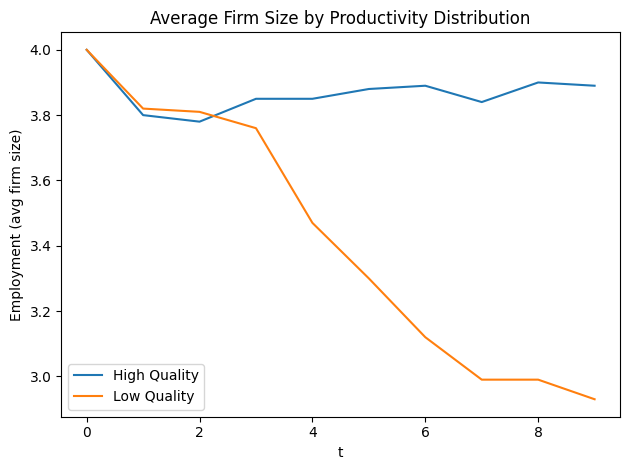

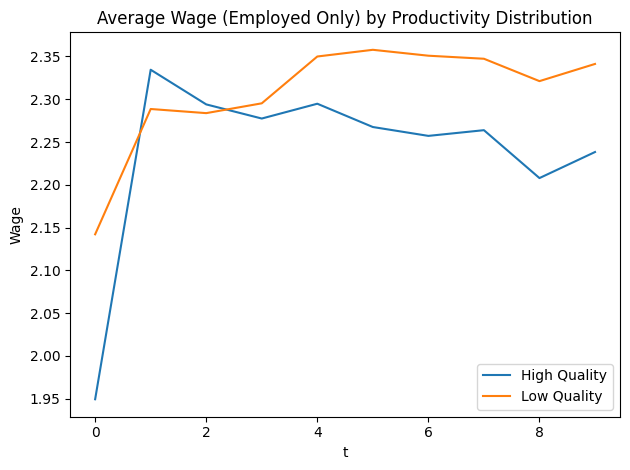

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Robust column setup ---
# ensure employment is 0/1
panel = panel_quality.copy()
panel['employed'] = (panel['f'] == 1).astype(int)

# find a wage column
for _cand in ['w', 'wage', 'W']:
    if _cand in panel.columns:
        w_col = _cand
        break
else:
    raise KeyError("Could not find a wage column among ['w','wage','W'].")

# --- (1) Average firm size by time and quality ---
# size per firm & time = number of employed workers
firm_size = (
    panel.groupby(['Quality','firm_id','t'], as_index=False)['employed']
         .sum()
         .rename(columns={'employed':'size'})
)

# IRF: average across firms at each time, by quality
size_irf = (
    firm_size.groupby(['Quality','t'], as_index=False)['size']
             .mean()
             .sort_values(['Quality','t'])
)

# --- (2) Average wage of employed workers by time and quality ---
wage_irf = (
    panel.loc[panel['employed'] == 1]
         .groupby(['Quality','t'], as_index=False)[w_col]
         .mean()
         .rename(columns={w_col:'avg_wage'})
         .sort_values(['Quality','t'])
)

# --- Plot helpers ---
def plot_lines(df, y, title, ylabel):
    plt.figure()
    for qual in sorted(df['Quality'].unique()):
        sub = df.loc[df['Quality'] == qual]
        plt.plot(sub['t'], sub[y], label=f'{qual} Quality')
    plt.xlabel('t')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plots
plot_lines(size_irf, 'size',      'Average Firm Size by Productivity Distribution', 'Employment (avg firm size)')
plot_lines(wage_irf, 'avg_wage',  'Average Wage (Employed Only) by Productivity Distribution', 'Wage')


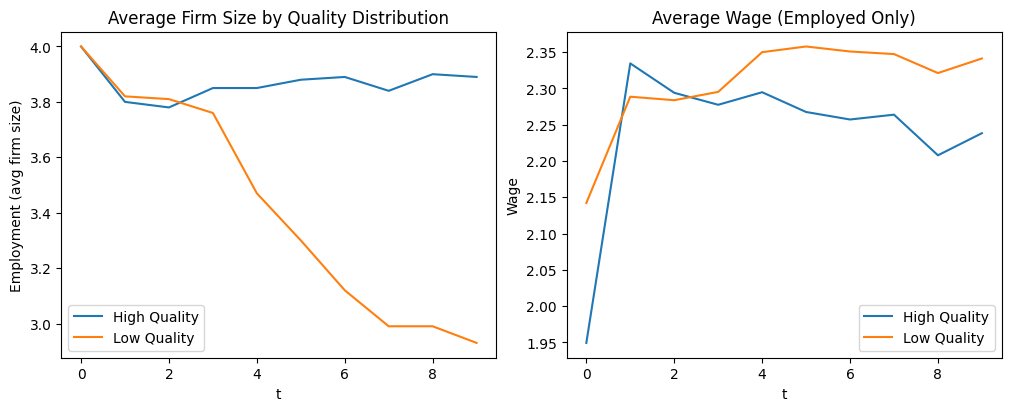

In [37]:
def plot_side_by_side(size_irf, wage_irf, fname_png='irf_quality_side_by_side.png', fname_pdf='irf_quality_side_by_side.pdf', label='Quality'):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, constrained_layout=True)

    # --- Left: Average firm size ---
    ax = axes[0]
    for qual in sorted(size_irf[label].unique()):
        sub = size_irf.loc[size_irf[label] == qual]
        ax.plot(sub['t'], sub['size'], label=f'{qual} {label}')
    ax.set_title(f'Average Firm Size by {label} Distribution')
    ax.set_xlabel('t')
    ax.set_ylabel('Employment (avg firm size)')
    ax.legend()

    # --- Right: Average wage (employed only) ---
    ax = axes[1]
    for qual in sorted(wage_irf[label].unique()):
        sub = wage_irf.loc[wage_irf[label] == qual]
        ax.plot(sub['t'], sub['avg_wage'], label=f'{qual} {label}')
    ax.set_title('Average Wage (Employed Only)')
    ax.set_xlabel('t')
    ax.set_ylabel('Wage')
    ax.legend()

    # Save once, two formats
    plt.savefig(fname_png, dpi=300, bbox_inches='tight')
    plt.savefig(fname_pdf, bbox_inches='tight')
    plt.show()

# call it
plot_side_by_side(size_irf, wage_irf)

In [40]:
#Now the same, but across tenure:
#Fix low productivity, compare tenure

BASE_SEED = 12345
import pandas as pd
(pr,rho,q,nt,allow_hiring,allow_leave,update_z,z_dir,seed) = (p.z_0-1,model.rho_grid[40],p.q_0,10, True,False,True,None,True)
nf = 100 #simulare 100 firms
def tenure_comparison(n0_init: float, n1_init: float, label: str) -> pd.DataFrame:
    """Run nf firms for a given starting q and return a concatenated DataFrame."""
    runs = []
    for firm_id in range(nf):
        # ensure different shocks but reproducible across whole experiment
        np.random.seed(BASE_SEED + firm_id)

        df = sim.simulate_firm(
            pr, n0_init, n1_init, rho, q, nt,
            allow_hiring=True, allow_fire=True, allow_leave=False,
            update_z=True, z_dir=None, seed=False, disable_fire=False
        )

        # annotate: firm id, scenario label, and unique worker id to avoid collisions
        df = df.assign(
            firm_id=firm_id,               # constant per run
            Tenure=label,                 # 'low' or 'high'
            n0=n0_init,                     # keep the numeric starting n0 if you want
            n1=n1_init,
            worker_uid=lambda d: d['i'].astype(int) + firm_id * 1_000_000
        )

        runs.append(df)

    return pd.concat(runs, ignore_index=True)

# run both scenarios
irf_low_tenure  = tenure_comparison(4,1, label='Younger')
irf_high_tenure = tenure_comparison(1,4,  label='Older')

# merged panel of every worker × time × firm, for both scenarios
panel_tenure = pd.concat([irf_low_tenure, irf_high_tenure], ignore_index=True)

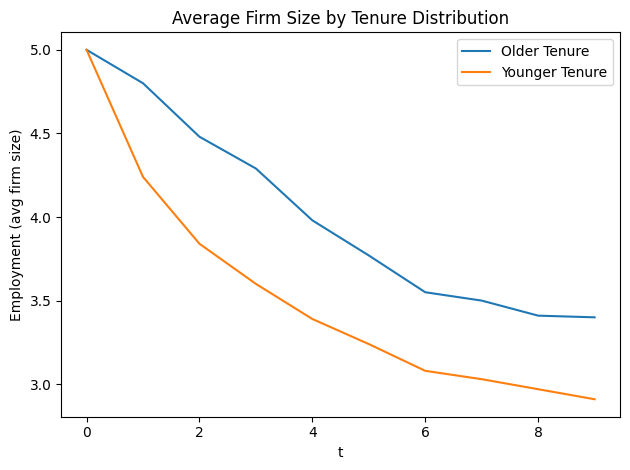

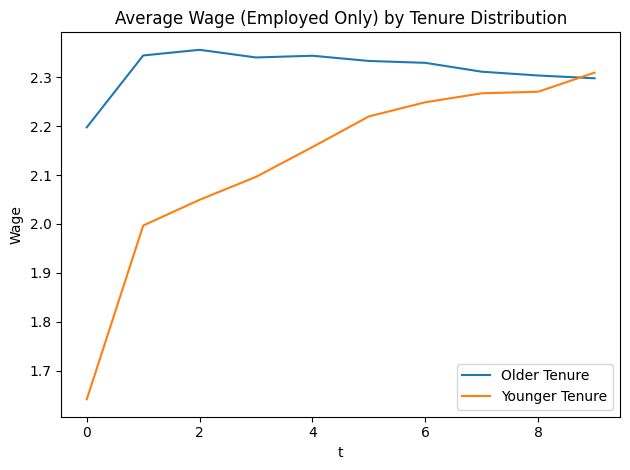

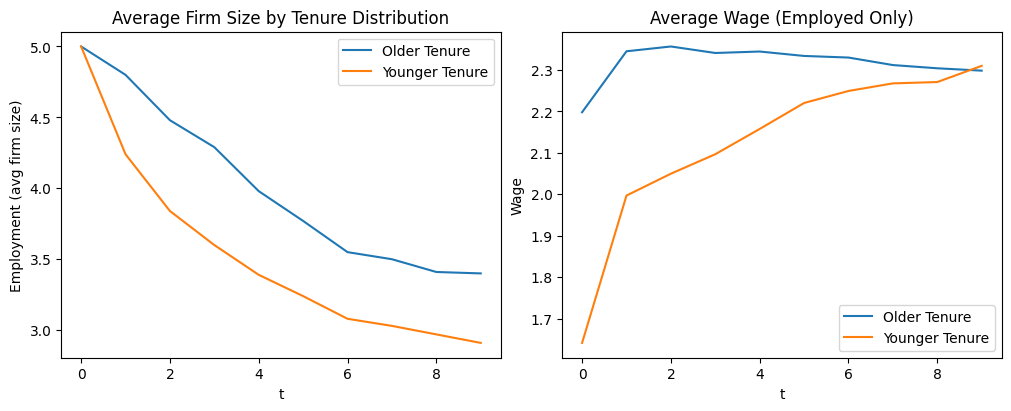

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Robust column setup ---
# ensure employment is 0/1
panel = panel_tenure.copy()
panel['employed'] = (panel['f'] == 1).astype(int)

# find a wage column
for _cand in ['w', 'wage', 'W']:
    if _cand in panel.columns:
        w_col = _cand
        break
else:
    raise KeyError("Could not find a wage column among ['w','wage','W'].")

# --- (1) Average firm size by time and tenure ---
# size per firm & time = number of employed workers
firm_size = (
    panel.groupby(['Tenure','firm_id','t'], as_index=False)['employed']
         .sum()
         .rename(columns={'employed':'size'})
)

# IRF: average across firms at each time, by quality
size_irf = (
    firm_size.groupby(['Tenure','t'], as_index=False)['size']
             .mean()
             .sort_values(['Tenure','t'])
)

# --- (2) Average wage of employed workers by time and quality ---
wage_irf = (
    panel.loc[panel['employed'] == 1]
         .groupby(['Tenure','t'], as_index=False)[w_col]
         .mean()
         .rename(columns={w_col:'avg_wage'})
         .sort_values(['Tenure','t'])
)

# --- Plot helpers ---
def plot_lines(df, y, title, ylabel):
    plt.figure()
    for ten in sorted(df['Tenure'].unique()):
        sub = df.loc[df['Tenure'] == ten]
        plt.plot(sub['t'], sub[y], label=f'{ten} Tenure')
    plt.xlabel('t')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plots
plot_lines(size_irf, 'size',      'Average Firm Size by Tenure Distribution', 'Employment (avg firm size)')
plot_lines(wage_irf, 'avg_wage',  'Average Wage (Employed Only) by Tenure Distribution', 'Wage')

# call it
plot_side_by_side(size_irf, wage_irf,fname_png='irf_tenure_side_by_side.png', fname_pdf='irf_tenure_side_by_side.pdf', label = "Tenure")

In [45]:
#Okay, how do I compare different firms across tenure/productivity? Do I simulate their paths? Or just focus ooon their optimal decisions?
#First, the easy apprach: optimal decisions
#Compare firms of the same tenure distribution, but different senior productivity:
n0 = 1
n1 = 3
np.mean((model.sep_star[:,n0,n1,:,0] * n0 + model.sep_star1[:,n0,n1,:,0] * n1) - (model.sep_star[:,n0,n1,:,5] * n0 + model.sep_star1[:,n0,n1,:,5] * n1))/ np.mean(model.sep_star[:,n0,n1,:,5] * n0 + model.sep_star1[:,n0,n1,:,5] * n1)
#np.mean((model.sep_star[...,0] + model.sep_star1[...,0]) - (model.sep_star[...,5] + model.sep_star1[...,5]))

np.float64(0.2710575028378266)

In [16]:
np.mean((model.sep_star[...,0] + model.sep_star1[...,0]))

np.float64(0.16213844514915146)

In [56]:
a = np.array([0,1,2])
a[1:]

array([1, 2])

In [ ]:
#Across tenure distribution. Note: no differences in productivity since seniors are also at the lowest quality here
# Intuition: the more juniors, the more layoffs, so the smaller wage growth. Ah but wait! The moore juniors, the more they mix in with seniors! So the wage growth of seniors may still be smaller... Fuck, again 2 steps is fucking me over
#Maybe, I then track the wage growth of surviving juniors? Nah, same shit, the rho_star itself is smaller.
#What about total (average) wage change? I guess, because there's a lot of juniors, the toootal growth will be larger for those guys. But still would be weird to claim this had anything to do with layoffs...
n_tot = 5
n0_j = 1
n0_s = 3
q = 0
np.mean((model.sep_star[:,n0_j,n_tot-n0_j,:,0] * n0_j + model.sep_star1[:,n0_j,n_tot-n0_j,:,0] * (n_tot-n0_j)) - (model.sep_star[:,n0_s,n_tot-n0_s,:,0] * n0_s + model.sep_star1[:,n0_s,n_tot-n0_s,:,0]  * (n_tot-n0_s))) / np.mean(model.sep_star[:,n0_s,n_tot-n0_s,:,0] * n0_s + model.sep_star1[:,n0_s,n_tot-n0_s,:,0]  * (n_tot-n0_s))


np.float64(-0.36746941145080997)

In [ ]:
#Now I want to do the same comparison in the simulation... right? To be fair, that's a lot harder. Let's first put it as is, then see what everyone thinks tonight/tomorrow
#or... how about I simulate those firms? and average them out??
#so, one simulation is comparing firms across quality, the other across tenure distribution!
#so this would be like sim.simulate_firm, but simulate multiple passes of that firm, and also with both layoffs (tho Ig it's already accounted for?)
#important part will be the wages: can I indeed show that the wage growth is better (long-term) when these firms fire? but this could be 2 slides already
#min wage policy implication could be okay... but what do I show? it's a lot of compute (gotta resolve with higher lower bar for w_grid and rho_grid), and it the end I'd get... what? I guess I could measure avg layoff rate + wage passthrough? also average productivity??


In [52]:
np.mean((model.rho_star[:,n0_j,n_tot-n0_j,:,0] - model.rho_star[:,n0_s,n_tot-n0_s,:,0]  )) / np.mean(model.rho_star[:,n0_s,n_tot-n0_s,:,0] - model.rho_grid[np.newaxis,:]) #Don't need the rho difference since it cancels out. But not in the denoominator!


np.float64(-0.49088285354459793)

In [7]:
sim.sdata['d']

NameError: name 'sim' is not defined

Kehoe exercise: look at wage cuts and layoffs for both jun and senior workers. SHiiiiiiiiiiiiit, I guess it's more complicated for me to do right now, since, after 1 period, jun and senior workers merge

So, what we do is: 
1. Compare a firm not firing vs firm firing, what happens to the wages? 
2. Show that it's mainly juniors being fired
3. Start at different initial rho's for seniors, what happens?

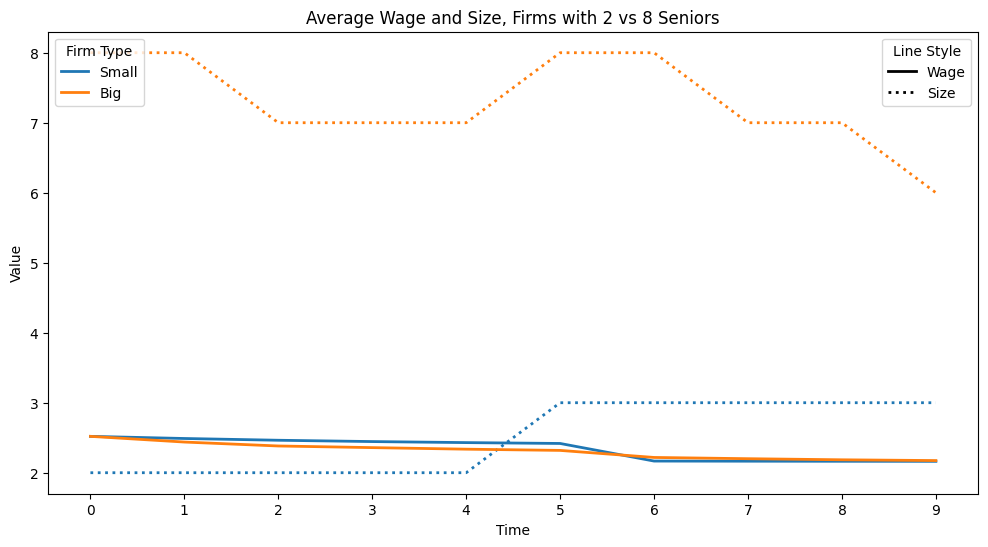

In [ ]:
#This gives us comparison across firm size: large and small firm, both hit prod shock at the same time
(pr,rho,q,nt,allow_hiring,allow_leave,update_z,z_dir,seed) = (p.z_0-1,model.rho_grid[40],p.q_0+0.0,10, True,False,True,None,True)

#Simulating a bunch of firms
irf_simul_all_small_neghock =     sim.simulate_firm(pr,0,2,rho,q,nt, allow_hiring=True,allow_fire=True,allow_leave=False,update_z=True, z_dir=-1,seed=True, disable_fire=False)
irf_simul_all_big_negshock =      sim.simulate_firm(pr,0,8,rho,q,nt, allow_hiring=True,allow_fire=True,allow_leave=False,update_z=True, z_dir=-1,seed=True, disable_fire=False)
#irf_simul_all_small_negshock_nofire =    sim.simulate_firm(pr,4,4,rho,q,nt, allow_hiring=True,allow_fire=True,allow_leave=False,update_z=True, z_dir=-1,seed=True, disable_fire=True)

#Print layoffs across the two firms
simulations = {
    'Small': irf_simul_all_small_neghock,
    'Big': irf_simul_all_big_negshock
    #'Small Neg no Fire': irf_simul_all_small_negshock_nofire,
}
def get_avg_wage_sen(sim_df):
    employed = sim_df[(sim_df['f'] > 0) & (sim_df['S'] > 1)]  # Employed senior workers only
    return employed.groupby('t')['w'].mean()
def get_sep_rate(sim_df):

    # Filter for employed juniors (f > 0 and S == 1)
    #juniors = sim_df[(sim_df['f'] > 0) & (sim_df['S'] == 1)]
    #employed = sim_df[sim_df['f'] > 0]
    # Group by time 't' and calculate the separation rate as the mean of the condition (D==3)
    sep_rate = sim_df.groupby('t')['D'].apply(lambda x: (x == 3).sum())
    return sep_rate

avg_sep = {name: get_sep_rate(df) for name, df in simulations.items()}
avg_wages = {name: get_avg_wage_sen(df) for name, df in simulations.items()}
avg_shock = {name: get_avg_column(df,'z') for name, df in simulations.items()}
avg_hirings = {name: get_avg_column(df,'n') for name, df in simulations.items()}

# Now create a plot using the same color for each simulation group
plt.figure(figsize=(12, 6))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, name in enumerate(simulations.keys()):
    color = colors[i % len(colors)]
    wage_series = avg_wages[name]
    hiring_series = avg_hirings[name]
    sep_series = avg_sep[name]
    #shock_series = avg_shock[name]        
    # Solid line for wage
    plt.plot(wage_series.index, wage_series, lw=2, color=color)
    # Dotted line for hiring
    plt.plot(hiring_series.index, hiring_series, lw=2, color=color, linestyle=':')
    #plt.plot(sep_series.index, sep_series, lw=2, color=color, linestyle=':')    
    #plt.plot(shock_series.index, shock_series, lw=2, color=color, linestyle='--')    

# Set discrete x-ticks based on the time points

all_times = np.sort(np.unique(np.concatenate([wage.index for wage in avg_wages.values()])))
plt.xticks(all_times, all_times)
#plt.xticks()

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Average Wage and Size, Firms with 2 vs 8 Seniors')

# Add the custom legends by calling the helper function
add_custom_legends(list(simulations.keys()),line_labels=['Wage','Size'])

plt.show()

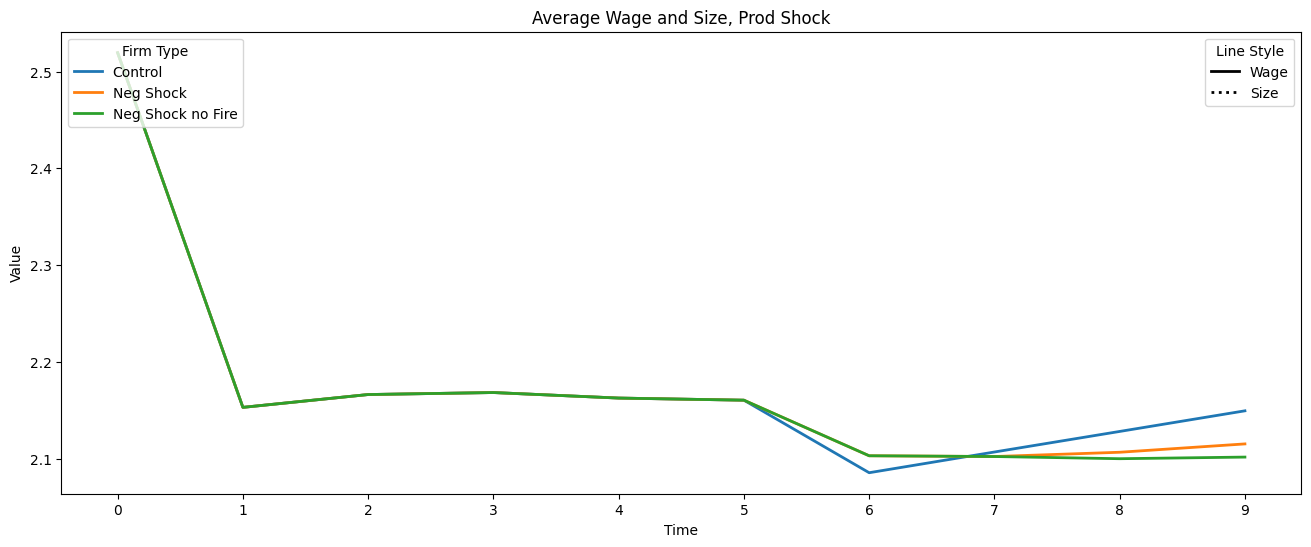

In [ ]:
#This gives us comparison across: firm with no prod shock, firm with neg shock, and same firm with neg shock but not allowed to fire after the shock
(pr,rho,q,nt,allow_hiring,allow_leave,update_z,z_dir,seed) = (p.z_0-1,model.rho_grid[40],p.q_0+0.0,10, True,False,True,None,True)

#Simulating a bunch of firms
irf_simul_all_small_noshock =     sim.simulate_firm(pr,4,4,rho,q,nt, allow_hiring=True,allow_fire=True,allow_leave=False,update_z=True, z_dir=0,seed=True, disable_fire=False)
irf_simul_all_small_negshock =    sim.simulate_firm(pr,4,4,rho,q,nt, allow_hiring=True,allow_fire=True,allow_leave=False,update_z=True, z_dir=-1,seed=True, disable_fire=False)
irf_simul_all_small_negshock_nofire =    sim.simulate_firm(pr,4,4,rho,q,nt, allow_hiring=True,allow_fire=True,allow_leave=False,update_z=True, z_dir=-1,seed=True, disable_fire=True)

#Print layoffs across the two firms
simulations = {
    'Control': irf_simul_all_small_noshock,
    'Neg Shock': irf_simul_all_small_negshock,
    'Neg Shock no Fire': irf_simul_all_small_negshock_nofire,
}
def get_avg_wage_sen(sim_df):
    employed = sim_df[(sim_df['f'] > 0) & (sim_df['S'] > 1)]  # Employed senior workers only
    return employed.groupby('t')['w'].mean()
def get_sep_rate(sim_df):

    # Filter for employed juniors (f > 0 and S == 1)
    #juniors = sim_df[(sim_df['f'] > 0) & (sim_df['S'] == 1)]
    #employed = sim_df[sim_df['f'] > 0]
    # Group by time 't' and calculate the separation rate as the mean of the condition (D==3)
    sep_rate = sim_df.groupby('t')['D'].apply(lambda x: (x == 3).sum())
    return sep_rate

avg_sep = {name: get_sep_rate(df) for name, df in simulations.items()}
avg_wages = {name: get_avg_wage_sen(df) for name, df in simulations.items()}
avg_shock = {name: get_avg_column(df,'z') for name, df in simulations.items()}
avg_hirings = {name: get_avg_column(df,'n') for name, df in simulations.items()}

# Now create a plot using the same color for each simulation group
plt.figure(figsize=(16, 6))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, name in enumerate(simulations.keys()):
    color = colors[i % len(colors)]
    wage_series = avg_wages[name]
    hiring_series = avg_hirings[name]
    sep_series = avg_sep[name]
    #shock_series = avg_shock[name]        
    # Solid line for wage
    plt.plot(wage_series.index, wage_series, lw=2, color=color)
    # Dotted line for hiring
    #plt.plot(hiring_series.index, hiring_series, lw=2, color=color, linestyle=':')
    #plt.plot(sep_series.index, sep_series, lw=2, color=color, linestyle=':')    
    #plt.plot(shock_series.index, shock_series, lw=2, color=color, linestyle='--')    

# Set discrete x-ticks based on the time points

all_times = np.sort(np.unique(np.concatenate([wage.index for wage in avg_wages.values()])))
plt.xticks(all_times, all_times)
#plt.xticks()

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Average Wage and Size, Prod Shock')

# Add the custom legends by calling the helper function
add_custom_legends(list(simulations.keys()),line_labels=['Wage','Size'])

plt.show()

Later, solve the model with CRS in order to check just the quality effect, without CRS contributing

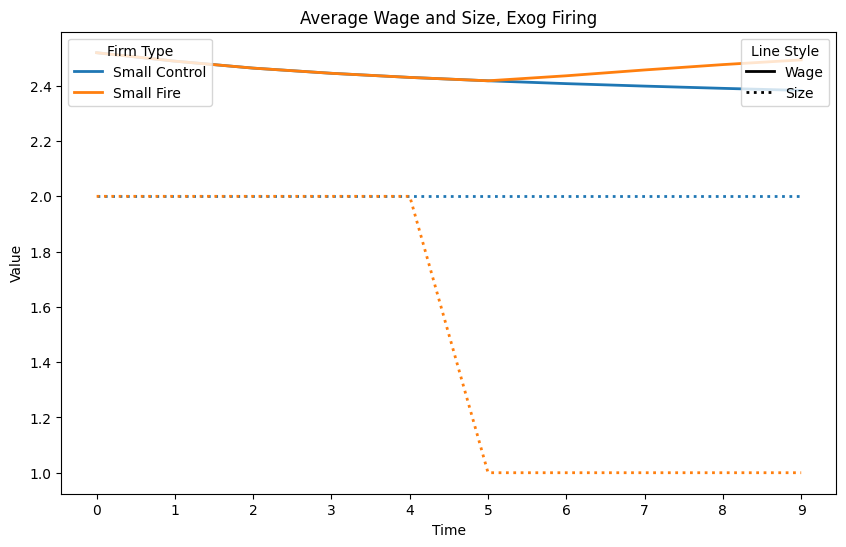

In [ ]:
#This gives us firm, constant prod, with and without being allowed to fire. Note that this DOESNT have a direct impact on quality since quality is calculated via model.q_star

(pr,rho,q,nt,allow_hiring,allow_leave,update_z,z_dir,seed) = (p.z_0-1,model.rho_grid[40],p.q_0+0.0,10, True,False,True,None,True)
irf_simul_all_small_nofire =  sim.simulate_firm_sep(pr,0,2,rho,q,nt, False,False,False,False,True,0,seed)
irf_simul_all_small_fire =  sim.simulate_firm_sep(pr,0,2,rho,q,nt, True,False,False,False,True,0,seed)

#Print layoffs across the two firms
simulations = {
    'Small Control': irf_simul_all_small_nofire,
    'Small Fire': irf_simul_all_small_fire
}
def get_avg_wage_sen(sim_df):
    employed = sim_df[(sim_df['f'] > 0) & (sim_df['S'] > 1)]  # Employed senior workers only
    return employed.groupby('t')['w'].mean()
def get_sep_rate(sim_df):
    # Filter for employed juniors (f > 0 and S == 1)
    #juniors = sim_df[(sim_df['f'] > 0) & (sim_df['S'] == 1)]
    #employed = sim_df[sim_df['f'] > 0]
    # Group by time 't' and calculate the separation rate as the mean of the condition (D==3)
    sep_rate = sim_df.groupby('t')['D'].apply(lambda x: (x == 3).sum())
    return sep_rate

avg_sep = {name: get_sep_rate(df) for name, df in simulations.items()}
avg_wages = {name: get_avg_wage_sen(df) for name, df in simulations.items()}
avg_size = {name: get_avg_column(df,'n') for name, df in simulations.items()}
#avg_hirings = {name: get_avg_hiring(df) for name, df in simulations.items()}

# Now create a plot using the same color for each simulation group
plt.figure(figsize=(10, 6))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, name in enumerate(simulations.keys()):
    color = colors[i % len(colors)]
    wage_series = avg_wages[name]
    #hiring_series = avg_hirings[name]
    sep_series = avg_sep[name]
    size_series = avg_size[name]        
    # Solid line for wage
    plt.plot(wage_series.index, wage_series, lw=2, color=color)
    # Dotted line for hiring
    plt.plot(size_series.index, size_series, lw=2, color=color, linestyle=':')
    #plt.plot(sep_series.index, sep_series, lw=2, color=color, linestyle=':')    
    #plt.plot(shock_series.index, shock_series, lw=2, color=color, linestyle='--')    

# Set discrete x-ticks based on the time points

all_times = np.sort(np.unique(np.concatenate([wage.index for wage in avg_wages.values()])))
plt.xticks(all_times, all_times)
#plt.xticks()

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Average Wage and Size, Exog Firing')

# Add the custom legends by calling the helper function
add_custom_legends(list(simulations.keys()),line_labels=['Wage','Size'])

plt.show()

Shock Path of the Firm

In [ ]:
(pr,rho,q,nt,allow_hiring,allow_leave,update_z,z_dir,seed) = (p.z_0-1,model.rho_grid[30],p.q_0,100, True,True,True,None,True)

In [ ]:
#Simulating a bunch of firms
irf_simul_young_small = sim.simulate_firm(pr,1,0,rho,q,nt, allow_hiring,allow_leave,update_z,z_dir,seed)
irf_simul_young_big =   sim.simulate_firm(pr,4,0,rho,q,nt, allow_hiring,allow_leave,update_z,z_dir,seed)
irf_simul_old_small =   sim.simulate_firm(pr,0,1,rho,q,nt, allow_hiring,allow_leave,update_z,z_dir,seed)
irf_simul_old_big =     sim.simulate_firm(pr,0,4,rho,q,nt, allow_hiring,allow_leave,update_z,z_dir,seed)
#irf_simul_all_small =   sim.simulate_firm(pr,1,1,rho,q,nt, allow_hiring,allow_leave,update_z,z_dir,seed)
#irf_simul_all_big =     sim.simulate_firm(pr,2,2,rho,q,nt, allow_hiring,allow_leave,update_z,z_dir,seed)

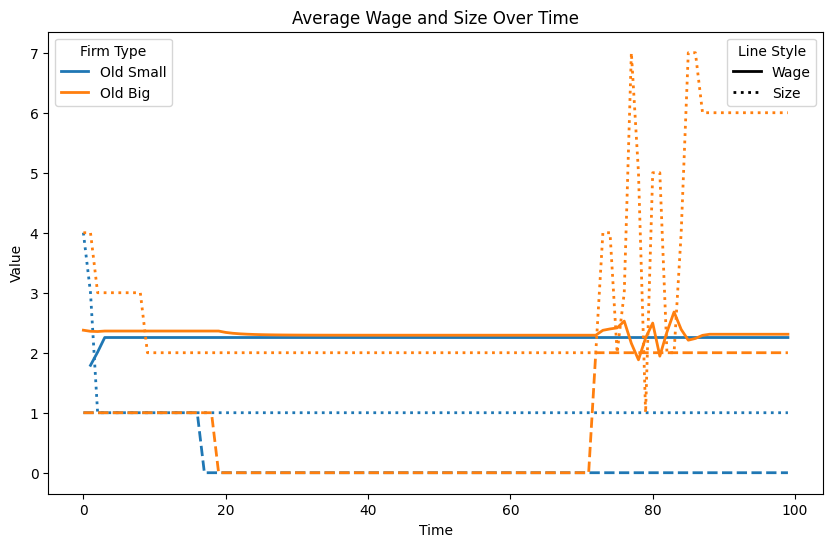

In [ ]:
# Example usage:
# Suppose you already have your simulation dictionary defined as:
simulations = {
    #'Young Small': irf_simul_young_small,
    'Old Small': irf_simul_young_big,
    #'Young Big': irf_simul_old_small,
    'Old Big': irf_simul_old_big
}

# And you've computed average wages and hiring as before:
def get_avg_wage(sim_df):
    employed = sim_df[sim_df['f'] > 0]  # Employed workers only
    return employed.groupby('t')['w'].mean()
def get_avg_wage_sen(sim_df):
    employed = sim_df[(sim_df['f'] > 0) & (sim_df['S'] > 1)]  # Employed senior workers only
    return employed.groupby('t')['w'].mean()

def get_avg_hiring(sim_df):
    return sim_df.groupby('t')['n0'].mean()

avg_size = {name: get_avg_column(df,'n') for name, df in simulations.items()}
avg_wages = {name: get_avg_wage_sen(df) for name, df in simulations.items()}
avg_shock = {name: get_avg_column(df,'z') for name, df in simulations.items()}
#avg_hirings = {name: get_avg_hiring(df) for name, df in simulations.items()}

# Now create a plot using the same color for each simulation group
plt.figure(figsize=(10, 6))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, name in enumerate(simulations.keys()):
    color = colors[i % len(colors)]
    wage_series = avg_wages[name]
    #hiring_series = avg_hirings[name]
    size_series = avg_size[name]
    shock_series = avg_shock[name]        
    # Solid line for wage
    plt.plot(wage_series.index, wage_series, lw=2, color=color)
    # Dotted line for hiring
    #plt.plot(hiring_series.index, hiring_series, lw=2, color=color, linestyle=':')
    plt.plot(size_series.index, size_series, lw=2, color=color, linestyle=':')    
    plt.plot(shock_series.index, shock_series, lw=2, color=color, linestyle='--')    

# Set discrete x-ticks based on the time points

all_times = np.sort(np.unique(np.concatenate([wage.index for wage in avg_wages.values()])))
#plt.xticks(all_times, all_times)
plt.xticks()

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Average Wage and Size Over Time')

# Add the custom legends by calling the helper function
add_custom_legends(list(simulations.keys()),line_labels=['Wage','Size'])

plt.show()

Comparing firm with/without shock

In [ ]:
(pr,rho,q,nt,allow_hiring,allow_leave,update_z,z_dir,seed) = (p.z_0-1,model.rho_grid[40],p.q_0,20, True,True,True,1,True)

In [ ]:
#Simulating a bunch of firms
irf_simul_young_small_noshock =     sim.simulate_firm(pr,0,1,rho,q,nt, allow_hiring,allow_leave,True,0,seed)
irf_simul_young_small_posshock =    sim.simulate_firm(pr,0,1,rho,q,nt, allow_hiring,allow_leave,True,1,seed)
irf_simul_young_small_negshock =    sim.simulate_firm(pr,0,1,rho,q,nt, allow_hiring,allow_leave,True,-1,seed)
#Big firms
irf_simul_young_big_noshock =     sim.simulate_firm(pr,0,5,rho,q,nt, allow_hiring,allow_leave,True,0,seed)
irf_simul_young_big_posshock =    sim.simulate_firm(pr,0,5,rho,q,nt, allow_hiring,allow_leave,True,1,seed)
irf_simul_young_big_negshock =    sim.simulate_firm(pr,0,5,rho,q,nt, allow_hiring,allow_leave,True,-1,seed)

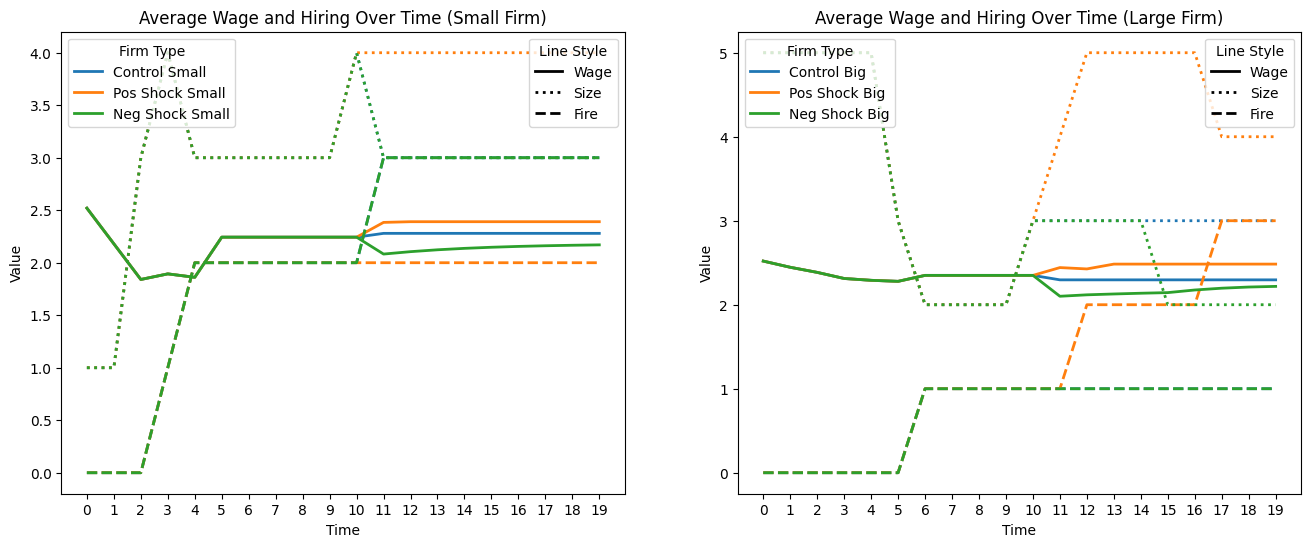

In [ ]:
# Example usage:
# Suppose you already have your simulation dictionary defined as:
simulations = {
    'Control Small': irf_simul_young_small_noshock,
    'Pos Shock Small': irf_simul_young_small_posshock,
    'Neg Shock Small': irf_simul_young_small_negshock,
    'Control Big': irf_simul_young_big_noshock,
    'Pos Shock Big': irf_simul_young_big_posshock,
    'Neg Shock Big': irf_simul_young_big_negshock,
#    'Old Big': irf_simul_old_big
}

# And you've computed average wages and hiring as before:
def get_avg_wage(sim_df):
    employed = sim_df[sim_df['f'] > 0]  # Employed workers only
    return employed.groupby('t')['w'].mean()
def get_avg_wage_sen(sim_df):
    employed = sim_df[(sim_df['f'] > 0) & (sim_df['S'] > 1)]  # Employed senior workers only
    return employed.groupby('t')['w'].mean()
def get_sep_rate(sim_df):
    # Filter for employed juniors (f > 0 and S == 1)
    #juniors = sim_df[(sim_df['f'] > 0) & (sim_df['S'] == 1)]
    #employed = sim_df[sim_df['f'] > 0]
    # Group by time 't' and calculate the separation rate as the mean of the condition (D==3)
    sep_rate = sim_df.groupby('t')['D'].apply(lambda x: (x == 3).sum())
    return sep_rate

avg_size = {name: get_avg_column(df,'n') for name, df in simulations.items()}
avg_wages = {name: get_avg_wage_sen(df) for name, df in simulations.items()}
avg_shock = {name: get_avg_column(df,'W1') for name, df in simulations.items()}
avg_sep = {name: get_sep_rate(df) for name, df in simulations.items()}
#avg_hirings = {name: get_avg_hiring(df) for name, df in simulations.items()}
small_names = ['Control Small', 'Pos Shock Small', 'Neg Shock Small']
big_names = ['Control Big', 'Pos Shock Big', 'Neg Shock Big']
# Now create a plot using the same color for each simulation group
plt.figure(figsize=(16, 6))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
for i, name in enumerate(small_names):
    color = colors[i % len(colors)]
    wage_series = avg_wages[name]
    #hiring_series = avg_hirings[name]
    size_series = avg_size[name]
    shock_series = avg_shock[name]  
    sep_series = avg_sep[name]      
    # Solid line for wage
    plt.plot(wage_series.index, wage_series, lw=2, color=color)
    plt.plot(size_series.index, size_series, lw=2, color=color, linestyle=':')  
    plt.plot(sep_series.index, sep_series, lw=2, color=color, linestyle='--')
    # Dotted line for hiring
    #plt.plot(hiring_series.index, hiring_series, lw=2, color=color, linestyle=':')
  
    #plt.plot(shock_series.index, shock_series, lw=2, color=color, linestyle='--')    

# Set discrete x-ticks based on the time points

all_times = np.sort(np.unique(np.concatenate([wage.index for wage in avg_wages.values()])))
plt.xticks(all_times, all_times)
#plt.xticks()

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Average Wage and Hiring Over Time (Small Firm)')
add_custom_legends(list(small_names),line_labels=['Wage','Size','Fire'])

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
for i, name in enumerate(big_names):
    color = colors[i % len(colors)]
    wage_series = avg_wages[name]
    #hiring_series = avg_hirings[name]
    size_series = avg_size[name]
    shock_series = avg_shock[name]
    sep_series = avg_sep[name]      
        
    # Solid line for wage
    plt.plot(wage_series.index, wage_series, lw=2, color=color)
    plt.plot(size_series.index, size_series, lw=2, color=color, linestyle=':')
    plt.plot(sep_series.index, sep_series, lw=2, color=color, linestyle='--')
    # Dotted line for hiring
    #plt.plot(hiring_series.index, hiring_series, lw=2, color=color, linestyle=':')
    
    #plt.plot(shock_series.index, shock_series, lw=2, color=color, linestyle='--')    

# Set discrete x-ticks based on the time points

all_times = np.sort(np.unique(np.concatenate([wage.index for wage in avg_wages.values()])))
plt.xticks(all_times, all_times)
#plt.xticks()

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Average Wage and Hiring Over Time (Large Firm)')

# Add the custom legends by calling the helper function
add_custom_legends(list(big_names),line_labels=['Wage','Size','Fire'])

plt.show()

In [ ]:
from numba import cuda, float64
import math

# Assume n_rho is known (e.g. 100)
NRHO = 100

@cuda.jit(device=True)
def interp_gpu(point, x, y, n):
    # Generic linear interpolation device function.
    if point <= x[0]:
        return y[0]
    elif point >= x[n-1]:
        return y[n-1]
    else:
        idx = 0
        for i in range(n - 1):
            if x[i] <= point and point < x[i+1]:
                idx = i
                break
        if x[idx+1] == x[idx]:
            return y[idx]
        return y[idx] + (point - x[idx]) * (y[idx+1] - y[idx]) / (x[idx+1] - x[idx])

@cuda.jit(device=True)
def find_rho_star(rho_grid, foc_slice, n_rho):
    # Given a monotonic foc_slice, return the rho value where foc crosses zero.
    if foc_slice[0] >= 0:
        return rho_grid[0]
    elif foc_slice[n_rho-1] <= 0:
        return rho_grid[n_rho-1]
    else:
        # Use interp_gpu to compute the zero crossing:
        return interp_gpu(0.0, rho_grid, foc_slice, n_rho)

@cuda.jit(device=True)
def compute_rho_star_for_indices(iz, in0, in1, iv, iq, foc, rho_grid, n_rho):
    # Load the foc slice for the given indices into a local array.
    # Note: NRHO must be >= n_rho.
    temp = cuda.local.array(NRHO, float64)
    for j in range(n_rho):
        temp[j] = foc[iz, in0, in1, j, iv, iq]
    # Enforce monotonicity on the foc slice.
    for j in range(1, n_rho):
        if temp[j] < temp[j-1]:
            temp[j] = temp[j-1]
    return find_rho_star(rho_grid, temp, n_rho)

@cuda.jit
def rho_star_kernel(pc, foc, rho_grid, N_grid, N_grid1, n_bar1, rho_star_out):
    """
    Cleaned-up kernel: each thread computes one element of rho_star_out,
    using the helper function compute_rho_star_for_indices.
    """
    pos = cuda.grid(1)
    num_z, num_n, num_n1, num_v, num_q = pc.shape
    total = num_z * num_n * num_n1 * num_v * num_q
    if pos >= total:
        return

    # Map the flat thread index to multi-dimensional indices.
    iq   = pos % num_q
    rem  = pos // num_q
    iv   = rem % num_v
    rem  = rem // num_v
    in1  = rem % num_n1
    rem  = rem // num_n1
    in0  = rem % num_n
    iz   = rem // num_n

    # Skip invalid combinations.
    if N_grid[in0] + N_grid1[in1] > n_bar1:
        rho_star_out[iz, in0, in1, iv, iq] = 0.0
        return

    # Compute rho_star for this combination using our device helper.
    rho_val = compute_rho_star_for_indices(iz, in0, in1, iv, iq, foc, rho_grid, foc.shape[3])
    rho_star_out[iz, in0, in1, iv, iq] = rho_val


In [ ]:
import numpy as np
import math
import time
from numba import cuda, float64, njit
import timeit
# Define dimensions (example values).
#num_z, num_n, num_n1, num_v, num_q = 3, 10, 8, 100, 5
#n_rho = 100  # length of rho_grid

# Create example input arrays.
pc   = np.random.rand(p.num_z, p.num_n, p.num_n1, p.num_v, p.num_q)
# Generate foc values in [-1, 1] to ensure a crossing exists.
foc  = np.random.rand(p.num_z, p.num_n, p.num_n1, 100, p.num_v, p.num_q) * 2 - 1
rho_grid = np.linspace(0, 1, 100)
N_grid   = np.linspace(0, p.n_bar, p.num_n)
N_grid1  = np.linspace(0, p.n_bar1, p.num_n1)
n_bar1   = p.n_bar1  # example threshold
# --------------------------------------
# CPU helper function using np.searchsorted
# --------------------------------------
@njit
def interp_cpu(point, x, y):
    """CPU interpolation as in your original interp function."""
    if point < x[0]:
        return y[0]
    elif point > x[-1]:
        return y[-1]
    else:
        idx = np.searchsorted(x, point) - 1
        # Avoid division by zero if x[idx+1]==x[idx]
        if x[idx+1] == x[idx]:
            return y[idx]
        return y[idx] + (point - x[idx]) * (y[idx+1] - y[idx]) / (x[idx+1] - x[idx])

# --------------------------------------
# CPU version for computing rho_star over all indices
# (mimics the logic used in your original function)
# --------------------------------------
@njit
def rho_star_cpu(pc, foc, rho_grid, N_grid, N_grid1, n_bar1):
    num_z, num_n, num_n1, num_v, num_q = pc.shape
    n_rho = foc.shape[3]
    rho_star_out = np.empty((num_z, num_n, num_n1, num_v, num_q), dtype=np.float64)
    for iz in range(num_z):
        for in0 in range(num_n):
            for in1 in range(num_n1):
                # Skip invalid combinations as in your code.
                if N_grid[in0] + N_grid1[in1] > n_bar1:
                    rho_star_out[iz, in0, in1, ...] = 0.0
                    continue
                for iv in range(num_v):
                    for iq in range(num_q):
                        # Get the foc slice corresponding to the rho_grid axis.
                        foc_slice = foc[iz, in0, in1, :, iv, iq].copy()
                        # Impose increasing (monotonic) order
                        for j in range(1, n_rho):
                            if foc_slice[j] < foc_slice[j-1]:
                                foc_slice[j] = foc_slice[j-1]
                        # Use interp_cpu to find the rho value at which foc crosses 0.
                        # This mimics: interp(0, rho_grid, foc_slice)
                        rho_star_out[iz, in0, in1, iv, iq] = interp_cpu(0, rho_grid, foc_slice)
    return rho_star_out

# --------------------------------------
# GPU device helper function (manual search, equivalent to np.searchsorted)
# --------------------------------------
@cuda.jit(device=True)
def interp_gpu(point, x, y, n):
    # If the point is outside the bounds, return the corresponding edge value.
    if point <= x[0]:
        return y[0]
    elif point >= x[n-1]:
        return y[n-1]
    else:
        idx = 0
        # Manually search for the index where x[idx] <= point < x[idx+1]
        for i in range(n - 1):
            if x[i] <= point and point < x[i+1]:
                idx = i
                break
        # Avoid division by zero.
        if x[idx+1] == x[idx]:
            return y[idx]
        return y[idx] + (point - x[idx]) * (y[idx+1] - y[idx]) / (x[idx+1] - x[idx])

# --------------------------------------
# GPU Kernel Version
# --------------------------------------

# --------------------------------------
# Main Comparison Script
# --------------------------------------
def cuda_compute(pc, foc, rho_grid, N_grid, N_grid1, n_bar1):


    # ----- Run GPU version -----
    start_gpu = time.time()
    # Transfer inputs to GPU.
    d_pc       = cuda.to_device(pc)
    d_foc      = cuda.to_device(foc)
    d_rho_grid = cuda.to_device(rho_grid)
    d_N_grid   = cuda.to_device(N_grid)
    d_N_grid1  = cuda.to_device(N_grid1)
    # Allocate output array on GPU.
    rho_star_shape = (p.num_z, p.num_n, p.num_n1, p.num_v, p.num_q)
    d_rho_star = cuda.device_array(rho_star_shape, dtype=np.float64)

    total_threads = np.prod(rho_star_shape)
    threads_per_block = 256
    blocks_per_grid = math.ceil(total_threads / threads_per_block)

    # Launch the GPU kernel.
    rho_star_kernel[blocks_per_grid, threads_per_block](d_pc, d_foc, d_rho_grid,
                                                          d_N_grid, d_N_grid1, n_bar1, d_rho_star)
    cuda.synchronize()
    rho_gpu = d_rho_star.copy_to_host()
    end_gpu = time.time()
    gpu_time = end_gpu - start_gpu
    return gpu_time



# ----- Run CPU version -----
#start_cpu = time.time()
#rho_cpu = rho_star_cpu(pc, foc, rho_grid, N_grid, N_grid1, n_bar1)
#end_cpu = time.time()
#cpu_time = end_cpu - start_cpu

# Timing Option A
time_a = timeit.timeit(lambda:rho_star_cpu(pc, foc, rho_grid, N_grid, N_grid1, n_bar1), number=100)
# Timing Option B
time_b = timeit.timeit(lambda:cuda_compute(pc, foc, rho_grid, N_grid, N_grid1, n_bar1), number=100)

print("Time for CPU : {:.4f} seconds".format(time_a))
print("Time for GPU : {:.4f} seconds".format(time_b))
# ----- Compare outputs and timings -----
#difference = np.abs(rho_cpu - rho_gpu).max()
#print("Max difference between CPU and GPU results:", difference)
#print("CPU time: {:.6f} s".format(cpu_time))
#print("GPU time: {:.6f} s".format(gpu_time))


NameError: name 'p' is not defined

In [ ]:
import numpy as np
d = np.array((2,1,0))
a = np.fmin(1/d,1)

C:\Users\andre\AppData\Local\Temp\ipykernel_16708\785944310.py:3: RuntimeWarning: divide by zero encountered in divide
  a = np.fmin(1/d,1)


In [ ]:
d=np.array((np.nan,1))
a=np.fmin(d,1)

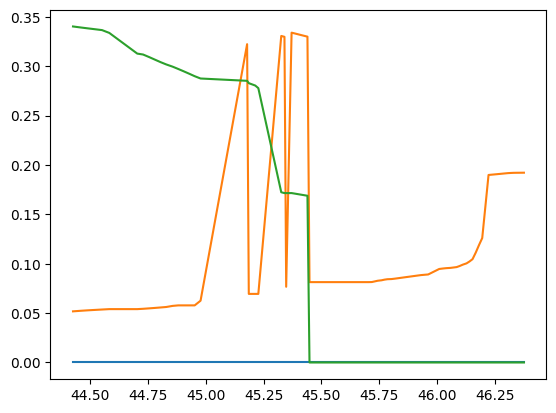

In [ ]:
prod = p.z_0-1
j=5
s=1
minv= 0
q = 0

#plt.plot(model.Vf_W[prod,j,s,:,q,1],model.Vf_J[prod,j,s,:,q])
#plt.plot(model.Vf_W[prod,j,s,:,q,1],model.Jp[prod,j,s,:,q])
#plt.plot(model.Vf_W[prod,j,s,:,q,1],model.EW_star[prod,j,s,:,q])

plt.plot(model.Vf_W[prod,j,s,:,q,1],model.n0_star[prod,j,s,:,q])
plt.plot(model.Vf_W[prod,j,s,:,q,1],model.sep_star[prod,j,s,:,q])
plt.plot(model.Vf_W[prod,j,s,:,q,1],model.sep_star1[prod,j,s,:,q])

In [ ]:
a

array([1, 2, 3])

In [ ]:
model.pe_star[2,0,4,48,0]

0.06191349709059191

Look in the data:
1. Passthrough of wages to shocks across firm size? Is the passthrough smaller, even negative, in small firms?
2. For firings: what happens to wages upon separation?

On theory:
Is math mathing here? Can a firm with higher prod be so much larger that its wages are lower?

With hiring and leaving (high prod)

In [ ]:
(pr,rho,q,nt,allow_hiring,allow_leave,update_z,z_dir,seed) = (p.z_0-1,30,p.q_0,10, True,False,True,1,False)

In [ ]:
#Simulating a bunch of firms
irf_simul_young_small = sim.simulate_firm(pr,1,0,rho,q,nt, allow_hiring,allow_leave,update_z,z_dir,seed)
irf_simul_young_big =   sim.simulate_firm(pr,4,0,rho,q,nt, allow_hiring,allow_leave,update_z,z_dir,seed)
irf_simul_old_small =   sim.simulate_firm(pr,0,1,rho,q,nt, allow_hiring,allow_leave,update_z,z_dir,seed)
irf_simul_old_big =     sim.simulate_firm(pr,0,4,rho,q,nt, allow_hiring,allow_leave,update_z,z_dir,seed)
irf_simul_all_small =   sim.simulate_firm(pr,1,1,rho,q,nt, allow_hiring,allow_leave,update_z,z_dir,seed)
irf_simul_all_big =     sim.simulate_firm(pr,2,2,rho,q,nt, allow_hiring,allow_leave,update_z,z_dir,seed)

In [ ]:


def add_custom_legends(simulation_names, line_labels=['Wage', 'Hiring'], line_styles=None, lw=2, sim_loc='upper left', style_loc='upper right'):
    """
    Adds custom legends to the current plot.
    
    Parameters:
    - simulation_names: list of str, names of your simulation groups.
    - lw: float, line width for the legend handles.
    - sim_loc: str, location for the simulation group legend.
    - style_loc: str, location for the line style legend.
    """
    # Get the default color cycle from matplotlib
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    # Create legend handles for simulation groups (colors)
    sim_handles = [Line2D([0], [0], color=colors[i % len(colors)], lw=lw)
                   for i, name in enumerate(simulation_names)]
    legend1 = plt.legend(sim_handles, simulation_names, title="Simulation Group", loc=sim_loc)
    
    # Use default line styles if none provided
    if line_styles is None:
        default_styles = ['-', ':', '--', '-.']
        line_styles = default_styles[:len(line_labels)]
    
    # Create legend handles for the line styles
    style_handles = [Line2D([0], [0], color='black', lw=lw, linestyle=ls) 
                     for ls in line_styles]
    legend2 = plt.legend(style_handles, line_labels, title="Line Style", loc=style_loc)
    
    # Ensure both legends appear on the plot
    plt.gca().add_artist(legend1)

# Example usage:
# Suppose you already have your simulation dictionary defined as:
simulations = {
    'Young Small': irf_simul_young_small,
    'Young Big': irf_simul_young_big,
#    'Old Small': irf_simul_old_small,
#    'Old Big': irf_simul_old_big
}

# And you've computed average wages and hiring as before:
def get_avg_wage(sim_df):
    employed = sim_df[sim_df['f'] > 0]  # Employed workers only
    return employed.groupby('t')['w'].mean()

def get_avg_hiring(sim_df):
    return sim_df.groupby('t')['n0'].mean()

avg_size = {name: get_avg_column(df,'n') for name, df in simulations.items()}
avg_wages = {name: get_avg_wage(df) for name, df in simulations.items()}
avg_shock = {name: get_avg_column(df,'z') for name, df in simulations.items()}
#avg_hirings = {name: get_avg_hiring(df) for name, df in simulations.items()}

# Now create a plot using the same color for each simulation group
plt.figure(figsize=(10, 6))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, name in enumerate(simulations.keys()):
    color = colors[i % len(colors)]
    wage_series = avg_wages[name]
    #hiring_series = avg_hirings[name]
    size_series = avg_size[name]
    shock_series = avg_shock[name]        
    # Solid line for wage
    plt.plot(wage_series.index, wage_series, lw=2, color=color)
    # Dotted line for hiring
    #plt.plot(hiring_series.index, hiring_series, lw=2, color=color, linestyle=':')
    plt.plot(size_series.index, size_series, lw=2, color=color, linestyle=':')    
    plt.plot(shock_series.index, shock_series, lw=2, color=color, linestyle='--')    

# Set discrete x-ticks based on the time points

all_times = np.sort(np.unique(np.concatenate([wage.index for wage in avg_wages.values()])))
plt.xticks(all_times, all_times)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Average Wage and Hiring Over Time (Discrete Time Axis)')

# Add the custom legends by calling the helper function
add_custom_legends(list(simulations.keys()),line_labels=['Wage', 'Size', 'Shock'])

plt.show()

AttributeError: 'DataFrame' object has no attribute 'grouseedy'

In [ ]:
#Young small plot, so understand why its wages stay the same
def get_avg_value(sim_df):
    employed = sim_df[sim_df['f'] > 0]
    # Average hiring is assumed to be in column 'n0'
    return employed.groupby('t')['W1'].mean()
avg_value = {name: get_avg_value(df) for name, df in simulations.items()}



# Plot for Small Firms
plt.figure(figsize=(8, 6))
for i, name in enumerate(small_names):
    color = colors[i % len(colors)]
    plt.plot(avg_wages[name].index, avg_wages[name], label=f'{name} Wage',color=color)
    # Plot average hiring (dotted line)
    #plt.plot(avg_hirings[name].index, avg_hirings[name], linestyle=':', label=f'{name} Hiring',color=color)
    # Plot average value 
    plt.plot(avg_prod[name].index, avg_prod[name], linestyle='dashdot', label=f'{name} Prod',color=color)    
# Combine all time points to set discrete ticks
all_times = np.sort(np.unique(np.concatenate([wage_series.index for wage_series in avg_wages.values()])))
plt.xticks(all_times, all_times)  # Set the x-axis ticks to the discrete time points

plt.title('Average Wage Over Time (Small Firms)')
plt.xlabel('Time')
plt.ylabel('Average Log Wage')
plt.legend()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'grouseedy'

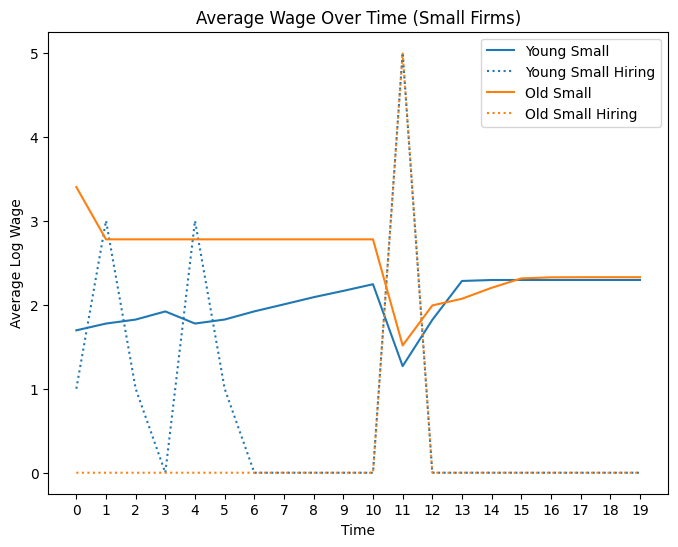

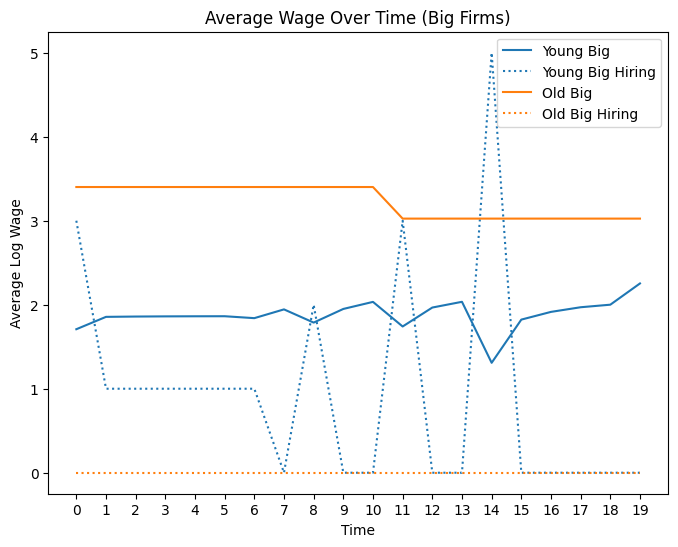

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Store your simulation DataFrames in a dictionary
simulations = {
    'Young Small': irf_simul_young_small,
    'Young Big': irf_simul_young_big,
    'Old Small': irf_simul_old_small,
    'Old Big': irf_simul_old_big,
    'All Small': irf_simul_all_small,
    'All Big': irf_simul_all_big
}

# Helper function to compute average wage over time (only for employed workers)
def get_avg_wage(sim_df):
    employed = sim_df[sim_df['f'] > 0]
    return employed.groupby('t')['w'].mean()
def get_avg_hiring(sim_df):
    employed = sim_df[sim_df['f'] > 0]
    # Average hiring is assumed to be in column 'n0'
    return employed.groupby('t')['n0'].mean()

# Compute average wages for each simulation and store them in a new dictionary
avg_wages = {name: get_avg_wage(df) for name, df in simulations.items()}
avg_hirings = {name: get_avg_hiring(df) for name, df in simulations.items()}


# Define groups for small and big firms
small_names = ['Young Small', 'Old Small']
big_names = ['Young Big', 'Old Big']
# Get Matplotlib's default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot for Small Firms
plt.figure(figsize=(8, 6))
for i, name in enumerate(small_names):
    color = colors[i % len(colors)]
    plt.plot(avg_wages[name].index, avg_wages[name], label=name,color=color)
    # Plot average hiring (dotted line)
    plt.plot(avg_hirings[name].index, avg_hirings[name], linestyle=':', label=f'{name} Hiring',color=color)
# Combine all time points to set discrete ticks
all_times = np.sort(np.unique(np.concatenate([wage_series.index for wage_series in avg_wages.values()])))
plt.xticks(all_times, all_times)  # Set the x-axis ticks to the discrete time points

plt.title('Average Wage Over Time (Small Firms)')
plt.xlabel('Time')
plt.ylabel('Average Log Wage')
plt.legend()
plt.show()

# Plot for Big Firms
plt.figure(figsize=(8, 6))
for i, name in enumerate(big_names):
    color = colors[i % len(colors)]
    plt.plot(avg_wages[name].index, avg_wages[name], label=name,color=color)
    # Plot average hiring (dotted line)
    plt.plot(avg_hirings[name].index, avg_hirings[name], linestyle=':', label=f'{name} Hiring',color=color)
# Combine all time points to set discrete ticks
all_times = np.sort(np.unique(np.concatenate([wage_series.index for wage_series in avg_wages.values()])))
plt.xticks(all_times, all_times)  # Set the x-axis ticks to the discrete time points

plt.title('Average Wage Over Time (Big Firms)')
plt.xlabel('Time')
plt.ylabel('Average Log Wage')
plt.legend()
plt.show()


Without hiring (low prod)

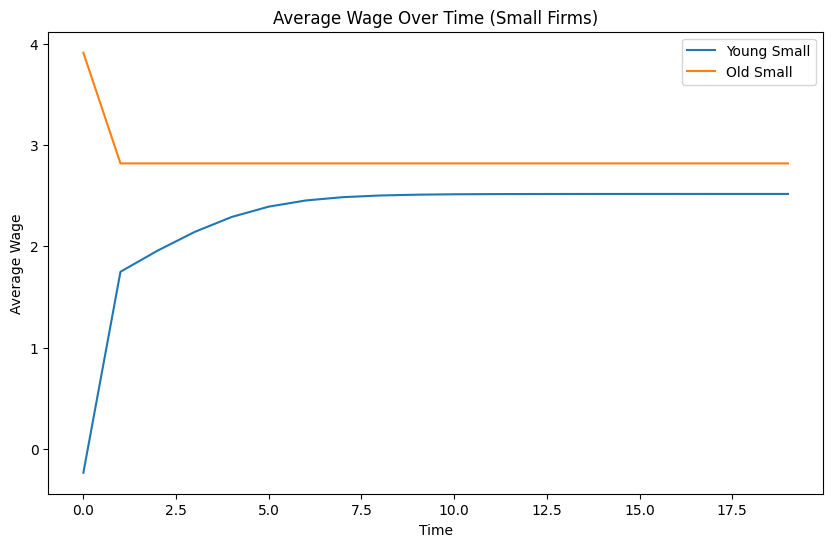

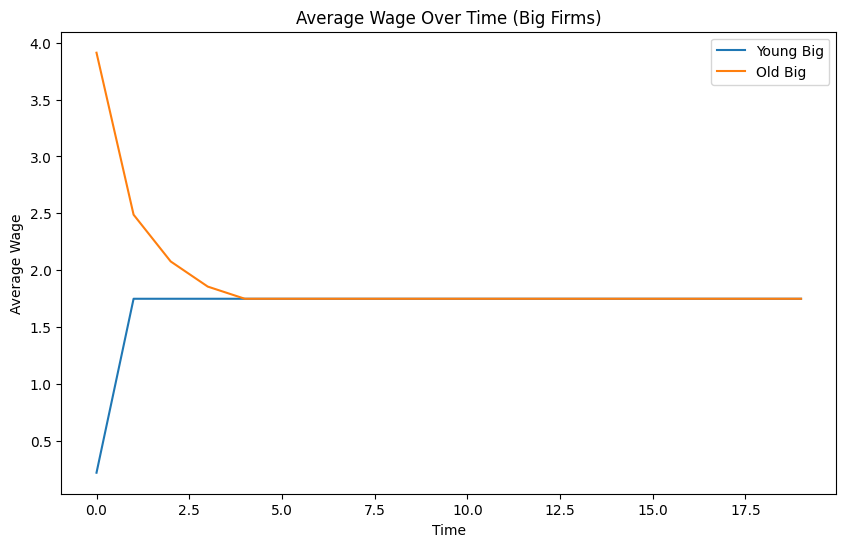

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Store your simulation DataFrames in a dictionary
simulations = {
    'Young Small': irf_simul_young_small,
    'Young Big': irf_simul_young_big,
    'Old Small': irf_simul_old_small,
    'Old Big': irf_simul_old_big,
    'All Small': irf_simul_all_small,
    'All Big': irf_simul_all_big
}

# Helper function to compute average wage over time (only for employed workers)
def get_avg_wage(sim_df):
    employed = sim_df[sim_df['f'] > 0]
    return employed.groupby('t')['w'].mean()

# Compute average wages for each simulation and store them in a new dictionary
avg_wages = {name: get_avg_wage(df) for name, df in simulations.items()}

# Define groups for small and big firms
small_names = ['Young Small', 'Old Small']
big_names = ['Young Big', 'Old Big']

# Plot for Small Firms
plt.figure(figsize=(10, 6))
for name in small_names:
    plt.plot(avg_wages[name].index, avg_wages[name], label=name)
plt.title('Average Wage Over Time (Small Firms)')
plt.xlabel('Time')
plt.ylabel('Average Wage')
plt.legend()
plt.show()

# Plot for Big Firms
plt.figure(figsize=(10, 6))
for name in big_names:
    plt.plot(avg_wages[name].index, avg_wages[name], label=name)
plt.title('Average Wage Over Time (Big Firms)')
plt.xlabel('Time')
plt.ylabel('Average Wage')
plt.legend()
plt.show()

# Alternatively, plot all simulations together
#plt.figure(figsize=(10, 6))
#for name, wage_series in avg_wages.items():
#    plt.plot(wage_series.index, wage_series, label=name)
#plt.title('Average Wage Over Time (All Simulations)')
#plt.xlabel('Time')
#plt.ylabel('Average Wage')
#plt.legend()
#plt.show()


Simulation timings

In [ ]:
from time import time
profiler = cProfile.Profile()
profiler.enable()
simul_result=sim.simulate_val()
profiler.disable()
# Print profiling results
stats = pstats.Stats(profiler).sort_stats(pstats.SortKey.TIME)
#stats.print_stats()

Exception ignored When destroying _lsprof profiler:
Traceback (most recent call last):
  File "C:\Users\andre\AppData\Local\Temp\ipykernel_7668\3578897233.py", line 3, in <module>
RuntimeError: Cannot install a profile function while another profile function is being installed


ValueError: NumPy boolean array indexing assignment cannot assign 1000 input values to the 0 output values where the mask is true

In [ ]:
from timeit import timeit
print("Simulation time:", timeit(sim.simulate_val(), number=10))

ValueError: NumPy boolean array indexing assignment cannot assign 1000 input values to the 0 output values where the mask is true

Time to perform 10 simulations:
Simulation time 1st time: 140.17326560002402
Simulation removed allocate_workers_to_vac_rand: 132.93263450000086
Simulation, when add z,prod,n0,n1 to the data at the end: 126.88947200000985
Simulation after removing closed firms from F_set: 133.41353940000408????
Simulation after removing closed firms from F_set, again, extra minor tweaks: 126.22359539999161
Simulation after setting initial prod back to avg: 195.49598599999445 OOOOOH Shit. tbf, the laptop also lost connection to the charger at some point, so this may have been that
Simulation after removing empty firms + vectorizing the 2d interpolation: 8.297498100000666
Simulation after vectorizing n0 and n1 counts: 4.869289499998558
Simulation after vectorizing prod interp: 3.3665357000136282
Final simulation (some minor updates ig?): 3.1729782999900635 

HUGE IMPROVEMENT